In [190]:
# import libraries 
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [191]:
# define random receiver 
def outcast(p,X,r):
    m = X.shape[1]
    x0,y0 = p
    x = y = np.arange(-r,r)
    x = x + x0
    y = y + y0

    u,v = np.meshgrid(x,y)
    u[u < 0] = 0
    u[u >= m] = m-1
    v[v < 0] = 0
    v[v >= m] = m-1
    
    return not np.any(X[u[:],v[:]] > 0)

def generate_samples(m=2500,r=200,k=30):
    '''
    m = extent of sample domain
    r = minimum distance between points
    k = samples before rejection
    '''
    active_list = []

    # step 0 - initialize n-d background grid
    X = np.ones((m,m))*-1

    # step 1 - select initial sample
    x0,y0 = np.random.randint(0,m), np.random.randint(0,m)
    active_list.append((x0,y0))
    X[active_list[0]] = 1

    # step 2 - iterate over active list
    while active_list:
        i = np.random.randint(0,len(active_list))
        rad = np.random.rand(k)*r+r
        theta = np.random.rand(k)*2*np.pi

        # get a list of random candidates within [r,2r] from the active point
        candidates = np.round((rad*np.cos(theta)+active_list[i][0],
                               rad*np.sin(theta)+active_list[i][1])).astype(np.int32).T

        # trim the list based on boundaries of the array
        candidates = [(x,y) for x,y in candidates if x >= 0 and y >= 0 and x < m and y < m]
        for p in candidates:
            if X[p] < 0 and outcast(p,X,r):
                X[p] = 1
                active_list.append(p)
                break
        else:
            del active_list[i]
    return X

In [166]:
# calculate receiver positions randomly
X = generate_samples(100, 10, 30)
rec = np.where(X > 0)
rec_x = rec[0] + 50.
rec_y = rec[1] + 50.
rec_z = rec[0] * 0. # put the receivers on the surface

In [192]:
! cat /import/deadlock-data/taufiqurrahman/MESS2018/experiment_Maeda2016/source.toml


[[source]]
name = "0000"
location = [127539.0, 76823.0, -60000.0]
spatial_type = "moment_tensor"
temporal_type = "ricker"
center_frequency = 0.25
scale = [1000000000.0, 1000000000.0, 1000000000.0, 0.0, 0.0, 0.0]


In [193]:
# put a source at depth
src_x = 127539. / 1000
src_y = 76823.  / 1000
src_z = -60000. / 1000

In [167]:
# define grid points
d = 10
grid = np.mgrid[50:150+d:d,50:150+d:d]
grid_x = np.reshape(grid[0], (grid[0,0].size)**2)
grid_y = np.reshape(grid[0], (grid[0,0].size)**2, order='F') # fortran-like index ordering
grid_z = grid_x * 0. # put the grid points on the surface

<IPython.core.display.Javascript object>


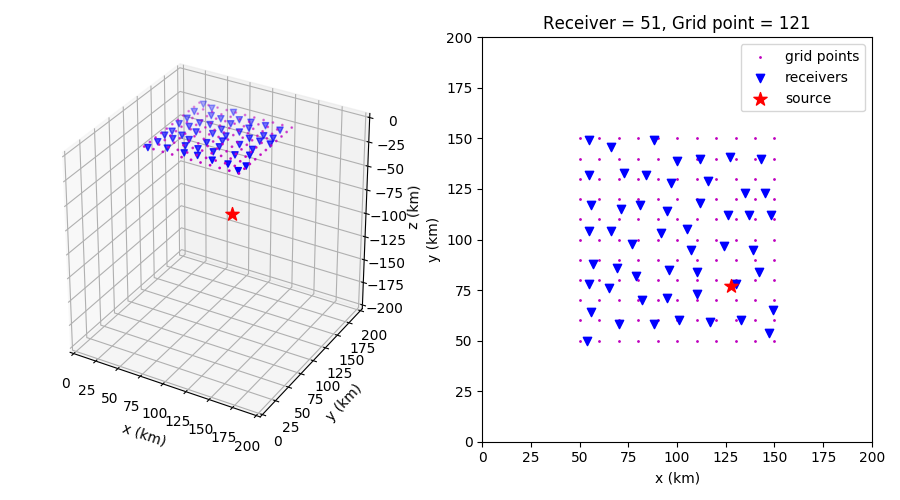

In [194]:
# plot configuration 
fig = plt.figure(figsize=(9,5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

# plot source and receiver positions in 3d and 2d
ax1.set_xlim(0,200)
ax1.set_ylim(0,200)
ax1.set_zlim(-200,0)
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')
ax1.set_zlabel('z (km)')
ax1.scatter(grid_x,grid_y, c='m', marker='o', s=1)
ax1.scatter(rec_x,rec_y,rec_z, c='b', marker='v')
ax1.scatter(src_x,src_y,src_z, c='r', marker='*', s=100)

ax2.set_xlim(0,200)
ax2.set_ylim(0,200)
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2.scatter(grid_x,grid_y, c='m', marker='o', s=1, label='grid points')
ax2.scatter(rec_x,rec_y, c='b', marker='v', label='receivers')
ax2.scatter(src_x,src_y, c='r', marker='*', s=100, label='source')
ax2.set_title('Receiver = {}, Grid point = {}'.format(rec_x.size,grid_x.size))
ax2.legend()

# show the result on screen
plt.tight_layout()
plt.show()

In [173]:
# output receiver's location to csv format 
csv_rec_out = '/import/deadlock-data/taufiqurrahman/MESS2018/experiment_Maeda2016/receiver.csv'
receiver = np.stack((rec_x.tolist(),rec_y.tolist(),rec_z.tolist()))
np.savetxt(csv_rec_out, receiver, delimiter=',', fmt='%f')

In [174]:
# output grid's location to csv format 
csv_grid_out = '/import/deadlock-data/taufiqurrahman/MESS2018/experiment_Maeda2016/grid.csv'
grid = np.stack((grid_x.tolist(),grid_y.tolist(),grid_z.tolist()))
np.savetxt(csv_grid_out, grid, delimiter=',', fmt='%f')

In [175]:
# input receiver's location from csv file 
csv_rec_in = np.loadtxt('/import/deadlock-data/taufiqurrahman/MESS2018/experiment_Maeda2016/receiver.csv', delimiter=',')

In [176]:
# input grid's location from csv file 
csv_grid_in = np.loadtxt('/import/deadlock-data/taufiqurrahman/MESS2018/experiment_Maeda2016/grid.csv', delimiter=',')

In [181]:
# create toml file which contains the receivers positions on the model's surface
with open("/import/deadlock-data/taufiqurrahman/MESS2018/experiment_Maeda2016/receiver.toml", "w") as text_file:
    for i in range(0,csv_rec_in[0].size):
        recLocX = csv_rec_in[0,i] * 1000. # convert x location to element location
        recLocY = csv_rec_in[1,i] * 1000. # convert y location to element location
        recLocZ = csv_rec_in[2,i]
        print("\n[[receiver]]", file=text_file)
        print("network = \"REC\"", file=text_file)
        print("station = \"{0:04}\"".format(i+1), file=text_file)
        print("medium = \"solid\"", file=text_file)
        print("salvus_coordinates = [{0}, {1}, {2}]".format(recLocX, recLocY, recLocZ), file=text_file)

In [182]:
! cat /import/deadlock-data/taufiqurrahman/MESS2018/experiment_Maeda2016/receiver.toml


[[receiver]]
network = "REC"
station = "0001"
medium = "solid"
salvus_coordinates = [54000.0, 50000.0, 0.0]

[[receiver]]
network = "REC"
station = "0002"
medium = "solid"
salvus_coordinates = [55000.0, 78000.0, 0.0]

[[receiver]]
network = "REC"
station = "0003"
medium = "solid"
salvus_coordinates = [55000.0, 104000.0, 0.0]

[[receiver]]
network = "REC"
station = "0004"
medium = "solid"
salvus_coordinates = [55000.0, 132000.0, 0.0]

[[receiver]]
network = "REC"
station = "0005"
medium = "solid"
salvus_coordinates = [55000.0, 149000.0, 0.0]

[[receiver]]
network = "REC"
station = "0006"
medium = "solid"
salvus_coordinates = [56000.0, 64000.0, 0.0]

[[receiver]]
network = "REC"
station = "0007"
medium = "solid"
salvus_coordinates = [56000.0, 117000.0, 0.0]

[[receiver]]
network = "REC"
station = "0008"
medium = "solid"
salvus_coordinates = [57000.0, 88000.0, 0.0]

[[receiver]]
network = "REC"
station = "0009"
medium = "solid"
salvus_coordinates = [65000.0, 76000.0, 0.0]

[[receiver]]
n

In [183]:
# create toml file which contains the grid points on the model's surface
with open("/import/deadlock-data/taufiqurrahman/MESS2018/experiment_Maeda2016/grid.toml", "w") as text_file:
    for i in range(0,csv_grid_in[0].size):
        recLocX = csv_grid_in[0,i] * 1000. # convert x location to element location
        recLocY = csv_grid_in[1,i] * 1000. # convert y location to element location
        recLocZ = csv_grid_in[2,i]
        print("\n[[receiver]]", file=text_file)
        print("network = \"GRID\"", file=text_file)
        print("station = \"{0:04}\"".format(i+1), file=text_file)
        print("medium = \"solid\"", file=text_file)
        print("salvus_coordinates = [{0}, {1}, {2}]".format(recLocX, recLocY, recLocZ), file=text_file)

In [184]:
! cat /import/deadlock-data/taufiqurrahman/MESS2018/experiment_Maeda2016/grid.toml


[[receiver]]
network = "GRID"
station = "0001"
medium = "solid"
salvus_coordinates = [50000.0, 50000.0, 0.0]

[[receiver]]
network = "GRID"
station = "0002"
medium = "solid"
salvus_coordinates = [50000.0, 60000.0, 0.0]

[[receiver]]
network = "GRID"
station = "0003"
medium = "solid"
salvus_coordinates = [50000.0, 70000.0, 0.0]

[[receiver]]
network = "GRID"
station = "0004"
medium = "solid"
salvus_coordinates = [50000.0, 80000.0, 0.0]

[[receiver]]
network = "GRID"
station = "0005"
medium = "solid"
salvus_coordinates = [50000.0, 90000.0, 0.0]

[[receiver]]
network = "GRID"
station = "0006"
medium = "solid"
salvus_coordinates = [50000.0, 100000.0, 0.0]

[[receiver]]
network = "GRID"
station = "0007"
medium = "solid"
salvus_coordinates = [50000.0, 110000.0, 0.0]

[[receiver]]
network = "GRID"
station = "0008"
medium = "solid"
salvus_coordinates = [50000.0, 120000.0, 0.0]

[[receiver]]
network = "GRID"
station = "0009"
medium = "solid"
salvus_coordinates = [50000.0, 130000.0, 0.0]

[[rec